#  Прогноз количества заказов для компании такси.

# Описание проекта
Заказчик - Компания такси - собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Надо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# План проекта

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

# Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

# План работы

1. Подготовка данных и загрузка библиотек
 * 1.1. Проверим порядок расположения индексов
2. Анализ
 * 2.1 Разложение на тренд, сезонность и остатки
 * 2.2. Выводы 
3. Обучение Моделей
 * 3.1. Разделим данные на тренировочную и тестовую выборку
 * 3.2. LinearRegression
 * 3.3. CatBoostRegressor
 * 3.4. Анализ результатов обучения
 * 3.5. Выводы
4. Тестирование модели
 * 4.1. CatBoostRegressor на тестовых данных
 * 4.2. График предсказания
 * 4.3. Итоговый Вывод

# 1. Подготовка данных и загрузка библиотек

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

RND = 12345

In [2]:
df = pd.read_csv('taxi.csv',index_col=[0], parse_dates=[0])

**1.1. Проверим порядок расположения индексов**

In [3]:
display(df.index.is_monotonic)

True

In [4]:
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:xlabel='datetime'>

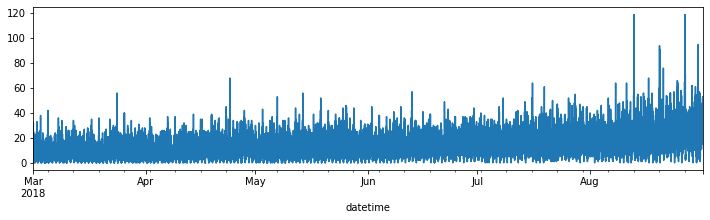

In [6]:
df.plot(legend=False, figsize=(12, 3), ax=plt.gca())

**Вывод:**

* Данные по заказам идут с интервалом в 10 мин.
* Пропуски отсутствуют.

Необходимо выполнить ресемплирование по одному часу.

In [7]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

<AxesSubplot:xlabel='datetime'>

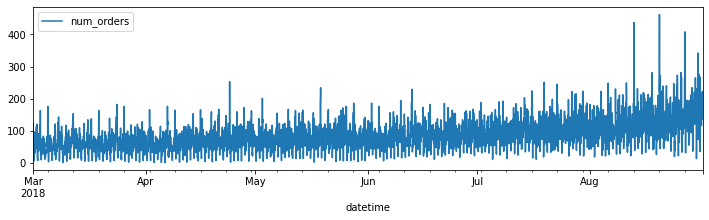

In [8]:
df.plot(figsize = (12, 3), ax=plt.gca())

# 2.1. Разложение на тренд, сезонность и остатки

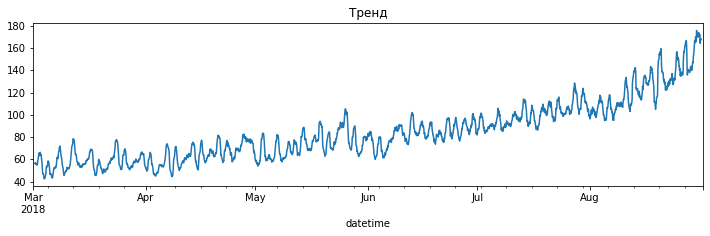

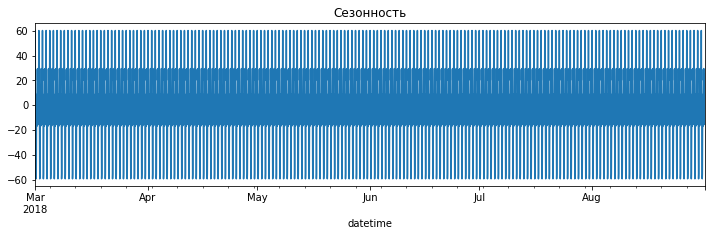

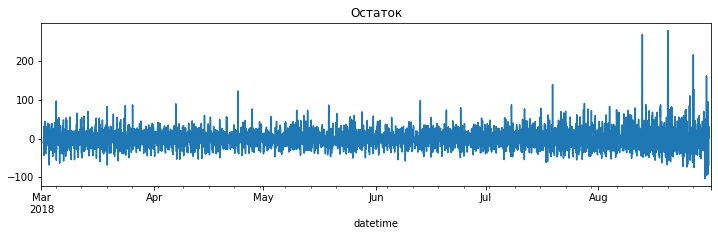

In [9]:
decomposed_data = seasonal_decompose(df)

decomposed_data.trend.plot(figsize = (12, 3))
plt.title('Тренд')
plt.show()

decomposed_data.seasonal.plot(figsize = (12, 3))
plt.title('Сезонность')
plt.show()
 
decomposed_data.resid.plot(figsize = (12, 3))
plt.title('Остаток')
plt.show()

**Вывод:** Рассмотрим более короткий период -  уменьшим интервал и посмотрим за две недели:

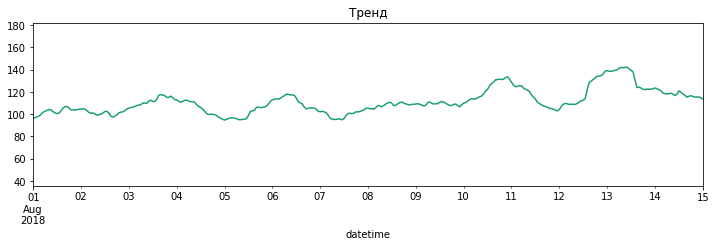

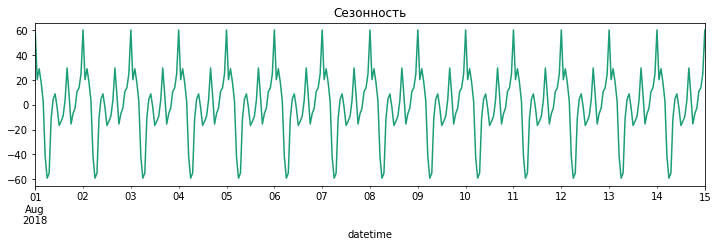

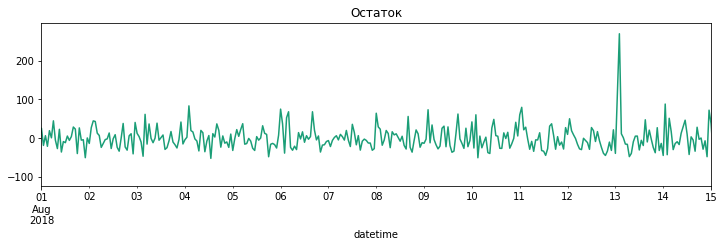

In [10]:
period = ['2018-08-01','2018-08-15']
decomposed_data.trend.plot(figsize = (12, 3), xlim=(period), color = ['#1b9e77', '#a9f971'])
plt.title('Тренд')
plt.show()
decomposed_data.seasonal.plot(figsize = (12, 3), xlim=(period), color = ['#1b9e77', '#a9f971'])
plt.title('Сезонность')
plt.show()
decomposed_data.resid.plot(figsize = (12, 3), xlim=(period), color = ['#1b9e77', '#a9f971'])
plt.title('Остаток')
plt.show()

# 2.2. Выводы 

Из графиков видно,что:

* ряд не стационарный. Тренд меняется со временем и не имеет значительных падений.

* прослеживается внутрисуточная сезонность.

* по месячная сезонность не наблюдается.

# 3. Обучение Моделей

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [12]:
df = make_features(df, 2, 24)

In [13]:
df = df.dropna()

# 3.1. Разделим данные на тренировочную и тестовую выборку

<AxesSubplot:title={'center':'Разделение датафрейма'}, ylabel='data'>

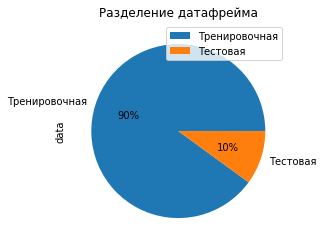

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('num_orders', axis=1), df.num_orders, shuffle=False, test_size=0.1, random_state=RND)
data_separation = pd.DataFrame({'name': ['Тренировочная',
                                         'Тестовая'],
                                'data': [
                                    X_train.shape[0],
                                    X_test.shape[0]]})
data_separation = data_separation.set_index('name')
data_separation.plot(kind='pie', y='data', autopct='%1.0f%%', title='Разделение датафрейма')

# 3.2. LinearRegression

In [15]:
model_lr = LinearRegression()

rmse = abs(cross_val_score(model_lr, X_train, y_train, 
                         cv = TimeSeriesSplit(n_splits=24), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean())

display(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', rmse)

'Значение метрики RMSE на обучающей выборке для LinearRegression'

30.64340255214117

# 3.3. CatBoostRegressor.

In [16]:
model_cat = CatBoostRegressor(iterations=100, 
                          verbose=False,
                          random_seed=RND)

params = {'depth': range(2, 10, 2)}
tscv = TimeSeriesSplit(n_splits = 24)
grid = GridSearchCV(model_cat, param_grid = params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv)
grid.fit(X_train, y_train) 

display('Лучшие параметры:', grid.best_params_)
display('CatBoostRegressor RMSE:', abs(grid.best_score_))

'Лучшие параметры:'

{'depth': 6}

'CatBoostRegressor RMSE:'

23.17575216337829

# 3.4. Анализ результатов обучения

In [17]:
results = {
    'Model' : ['LinearRegression', 'CatBoostRegressor'],
    'RMSE_model': pd.Series([30.64,24.78])
    }
display(pd.DataFrame(results))

,Model,RMSE_model
0,LinearRegression,30.64
1,CatBoostRegressor,24.78


<AxesSubplot:>

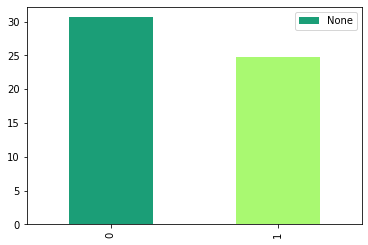

In [18]:
results['RMSE_model'].plot(kind='bar', legend=True, color = ['#1b9e77', '#a9f971'])

# 3.5. Выводы

Проведено обучение моделей:

* LinearRegression.

* CatBoostRegressor.

Все модели достаточно быстро обучались.Самое короткое время обучения и предсказания получено у Линейной регрессии.

Лучшее значение RMSE получено у CatBoostRegressor и составляет: 24.78. Эти результаты получены при depth=4.

# 4. Тестирование модели

# 4.1. CatBoostRegressor на тестовых данных

In [19]:
cat_model = CatBoostRegressor(eval_metric='RMSE', 
                          iterations=100,
                          depth = 6,
                          verbose=False,
                          use_best_model=False,
                          random_seed=RND)

cat_model.fit(X_train, y_train)

cat_predictions = cat_model.predict(X_test)
rmse = mean_squared_error(y_test, cat_predictions, squared=False)

display('*'*30)
display('CatBoostRegressor RMSE:', rmse)
display('*'*30)

'******************************'

'CatBoostRegressor RMSE:'

45.974400644811496

'******************************'

# 4.2. График предсказания

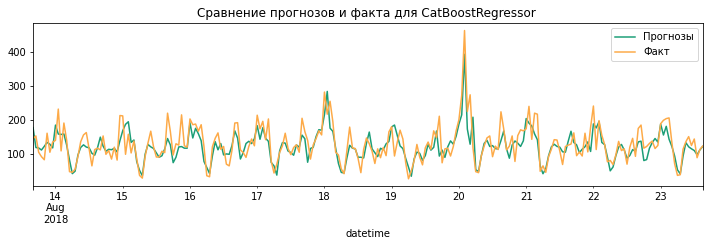

In [20]:
pd.DataFrame({'Прогнозы':cat_predictions,
             'Факт':y_test})[:240].plot(figsize=(12, 3), color = ['#1b9e77', '#fdaa48'])
plt.title('Сравнение прогнозов и факта для CatBoostRegressor ')
plt.show()

# 4.3. Итоговый Вывод

Мы провели исследование временного ряда на предмет трендовых и сезонных закономерностей, случайной составляющей. Выяснили, что ряд имеет следующие характеристики:

В процессе обучения рассматривались модели:

* LinearRegression.

* CatBoostRegressor.

Все модели достаточно быстро обучались.

Наилучшие показатели на тестовых данных были получены у CatBoostRegressor при iterations=100 и depth=6,:

* RMSE = 45.97

Целью работы было достижение значения RMSE < 48 на тестовых данных. С этой задачей лучше всего справился CatBoostRegressor.
При iterations=100 и depth=4 

CatBoostRegressor рекомендуется для дальнейшего использования.

И ещё один момент - при эксплуатации предусмотреть переобучение модели каждую неделю. Характеристики временных рядов постепенно уходят. Модель должна следить за этим.